In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import os
import sys
from PIL import Image
import json
import cv2
import math
from tqdm import tqdm

In [3]:

class YOLOv8_face:
    def __init__(self, path, conf_thres=0.2, iou_thres=0.5):
        self.conf_threshold = conf_thres
        self.iou_threshold = iou_thres
        self.class_names = ['face']
        self.num_classes = len(self.class_names)
        
        # Initialize model
        self.net = cv2.dnn.readNet(path)
        self.input_height = 640
        self.input_width = 640
        self.reg_max = 16

        self.project = np.arange(self.reg_max)
        self.strides = (8, 16, 32)
        self.feats_hw = [(math.ceil(self.input_height / self.strides[i]), math.ceil(self.input_width / self.strides[i])) for i in range(len(self.strides))]
        self.anchors = self.make_anchors(self.feats_hw)

    def make_anchors(self, feats_hw, grid_cell_offset=0.5):
        """Generate anchors from features."""
        anchor_points = {}
        for i, stride in enumerate(self.strides):
            h,w = feats_hw[i]
            x = np.arange(0, w) + grid_cell_offset  # shift x
            y = np.arange(0, h) + grid_cell_offset  # shift y
            sx, sy = np.meshgrid(x, y)
            # sy, sx = np.meshgrid(y, x)
            anchor_points[stride] = np.stack((sx, sy), axis=-1).reshape(-1, 2)
        return anchor_points

    def softmax(self, x, axis=1):
        x_exp = np.exp(x)
        # 如果是列向量，则axis=0
        x_sum = np.sum(x_exp, axis=axis, keepdims=True)
        s = x_exp / x_sum
        return s
    
    def resize_image(self, srcimg, keep_ratio=True):
        top, left, newh, neww = 0, 0, self.input_width, self.input_height
        if keep_ratio and srcimg.shape[0] != srcimg.shape[1]:
            hw_scale = srcimg.shape[0] / srcimg.shape[1]
            if hw_scale > 1:
                newh, neww = self.input_height, int(self.input_width / hw_scale)
                img = cv2.resize(srcimg, (neww, newh), interpolation=cv2.INTER_AREA)
                left = int((self.input_width - neww) * 0.5)
                img = cv2.copyMakeBorder(img, 0, 0, left, self.input_width - neww - left, cv2.BORDER_CONSTANT,
                                         value=(0, 0, 0))  # add border
            else:
                newh, neww = int(self.input_height * hw_scale), self.input_width
                img = cv2.resize(srcimg, (neww, newh), interpolation=cv2.INTER_AREA)
                top = int((self.input_height - newh) * 0.5)
                img = cv2.copyMakeBorder(img, top, self.input_height - newh - top, 0, 0, cv2.BORDER_CONSTANT,
                                         value=(0, 0, 0))
        else:
            img = cv2.resize(srcimg, (self.input_width, self.input_height), interpolation=cv2.INTER_AREA)
        return img, newh, neww, top, left

    def detect(self, srcimg):
        input_img, newh, neww, padh, padw = self.resize_image(cv2.cvtColor(srcimg, cv2.COLOR_BGR2RGB))
        scale_h, scale_w = srcimg.shape[0]/newh, srcimg.shape[1]/neww
        input_img = input_img.astype(np.float32) / 255.0

        blob = cv2.dnn.blobFromImage(input_img)
        self.net.setInput(blob)
        outputs = self.net.forward(self.net.getUnconnectedOutLayersNames())
        # if isinstance(outputs, tuple):
        #     outputs = list(outputs)
        # if float(cv2.__version__[:3])>=4.7:
        #     outputs = [outputs[2], outputs[0], outputs[1]] ###opencv4.7需要这一步，opencv4.5不需要
        # Perform inference on the image
        det_bboxes, det_conf, det_classid, landmarks = self.post_process(outputs, scale_h, scale_w, padh, padw)
        return det_bboxes, det_conf, det_classid, landmarks

    def post_process(self, preds, scale_h, scale_w, padh, padw):
        bboxes, scores, landmarks = [], [], []
        for i, pred in enumerate(preds):
            stride = int(self.input_height/pred.shape[2])
            pred = pred.transpose((0, 2, 3, 1))
            
            box = pred[..., :self.reg_max * 4]
            cls = 1 / (1 + np.exp(-pred[..., self.reg_max * 4:-15])).reshape((-1,1))
            kpts = pred[..., -15:].reshape((-1,15)) ### x1,y1,score1, ..., x5,y5,score5

            # tmp = box.reshape(self.feats_hw[i][0], self.feats_hw[i][1], 4, self.reg_max)
            tmp = box.reshape(-1, 4, self.reg_max)
            bbox_pred = self.softmax(tmp, axis=-1)
            bbox_pred = np.dot(bbox_pred, self.project).reshape((-1,4))

            bbox = self.distance2bbox(self.anchors[stride], bbox_pred, max_shape=(self.input_height, self.input_width)) * stride
            kpts[:, 0::3] = (kpts[:, 0::3] * 2.0 + (self.anchors[stride][:, 0].reshape((-1,1)) - 0.5)) * stride
            kpts[:, 1::3] = (kpts[:, 1::3] * 2.0 + (self.anchors[stride][:, 1].reshape((-1,1)) - 0.5)) * stride
            kpts[:, 2::3] = 1 / (1+np.exp(-kpts[:, 2::3]))

            bbox -= np.array([[padw, padh, padw, padh]])  ###合理使用广播法则
            bbox *= np.array([[scale_w, scale_h, scale_w, scale_h]])
            kpts -= np.tile(np.array([padw, padh, 0]), 5).reshape((1,15))
            kpts *= np.tile(np.array([scale_w, scale_h, 1]), 5).reshape((1,15))

            bboxes.append(bbox)
            scores.append(cls)
            landmarks.append(kpts)

        bboxes = np.concatenate(bboxes, axis=0)
        scores = np.concatenate(scores, axis=0)
        landmarks = np.concatenate(landmarks, axis=0)
    
        bboxes_wh = bboxes.copy()
        bboxes_wh[:, 2:4] = bboxes[:, 2:4] - bboxes[:, 0:2]  ####xywh
        classIds = np.argmax(scores, axis=1)
        confidences = np.max(scores, axis=1)  ####max_class_confidence
        
        mask = confidences>self.conf_threshold
        bboxes_wh = bboxes_wh[mask]  ###合理使用广播法则
        if bboxes_wh.size==0:
            print('nothing detect')
            return np.array([]), np.array([]), np.array([]), np.array([])
        confidences = confidences[mask]
        classIds = classIds[mask]
        landmarks = landmarks[mask]
        
        indices = cv2.dnn.NMSBoxes(bboxes_wh.tolist(), confidences.tolist(), self.conf_threshold,
                                   self.iou_threshold).flatten()
        if len(indices) > 0:
            mlvl_bboxes = bboxes_wh[indices]
            confidences = confidences[indices]
            classIds = classIds[indices]
            landmarks = landmarks[indices]
            return mlvl_bboxes, confidences, classIds, landmarks
        else:
            print('nothing detect')
            return np.array([]), np.array([]), np.array([]), np.array([])

    def distance2bbox(self, points, distance, max_shape=None):
        x1 = points[:, 0] - distance[:, 0]
        y1 = points[:, 1] - distance[:, 1]
        x2 = points[:, 0] + distance[:, 2]
        y2 = points[:, 1] + distance[:, 3]
        if max_shape is not None:
            x1 = np.clip(x1, 0, max_shape[1])
            y1 = np.clip(y1, 0, max_shape[0])
            x2 = np.clip(x2, 0, max_shape[1])
            y2 = np.clip(y2, 0, max_shape[0])
        return np.stack([x1, y1, x2, y2], axis=-1)
    
    def draw_detections(self, image, boxes, scores, kpts):
        for box, score, kp in zip(boxes, scores, kpts):
            x, y, w, h = box.astype(int)
            # Draw rectangle
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 255), thickness=1)
            cv2.putText(image, "face:"+str(round(score,2)), (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), thickness=1)
            for i in range(5):
                cv2.circle(image, (int(kp[i * 3]), int(kp[i * 3 + 1])), 2, (0, 255, 0), thickness=-1)
                # cv2.putText(image, str(i), (int(kp[i * 3]), int(kp[i * 3 + 1]) - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), thickness=1)
        return image

imgpath = '/home/syeda/testVLR/p_00a4eda7.jpg'
modelpath = '/ocean/projects/cis220031p/abdulhan/VLR/yolov8n-face_demo.onnx'
confThreshold = 0.45
nmsThreshold = 0.45 

# Initialize YOLOv8_face object detector
YOLOv8_face_detector = YOLOv8_face(modelpath, conf_thres=confThreshold, iou_thres=nmsThreshold)

In [155]:

# class YOLOv8_face:
#     def __init__(self, path, conf_thres=0.2, iou_thres=0.5):
#         self.conf_threshold = conf_thres
#         self.iou_threshold = iou_thres
#         self.class_names = ['face']
#         self.num_classes = len(self.class_names)
        
#         # Initialize model
#         self.net = cv2.dnn.readNet(path)
#         self.input_height = 640
#         self.input_width = 640
#         self.reg_max = 16

#         self.project = np.arange(self.reg_max)
#         self.strides = (8, 16, 32)
#         self.feats_hw = [(math.ceil(self.input_height / self.strides[i]), math.ceil(self.input_width / self.strides[i])) for i in range(len(self.strides))]
#         self.anchors = self.make_anchors(self.feats_hw)

#     def make_anchors(self, feats_hw, grid_cell_offset=0.5):
#         """Generate anchors from features."""
#         anchor_points = {}
#         for i, stride in enumerate(self.strides):
#             h,w = feats_hw[i]
#             x = np.arange(0, w) + grid_cell_offset  # shift x
#             y = np.arange(0, h) + grid_cell_offset  # shift y
#             sx, sy = np.meshgrid(x, y)
#             # sy, sx = np.meshgrid(y, x)
#             anchor_points[stride] = np.stack((sx, sy), axis=-1).reshape(-1, 2)
#         return anchor_points

#     def softmax(self, x, axis=1):
#         x_exp = np.exp(x)
#         # 如果是列向量，则axis=0
#         x_sum = np.sum(x_exp, axis=axis, keepdims=True)
#         s = x_exp / x_sum
#         return s
    
#     def resize_image(self, srcimg, keep_ratio=True):
#         top, left, newh, neww = 0, 0, self.input_width, self.input_height
#         if keep_ratio and srcimg.shape[0] != srcimg.shape[1]:
#             hw_scale = srcimg.shape[0] / srcimg.shape[1]
#             if hw_scale > 1:
#                 newh, neww = self.input_height, int(self.input_width / hw_scale)
#                 img = cv2.resize(srcimg, (neww, newh), interpolation=cv2.INTER_AREA)
#                 left = int((self.input_width - neww) * 0.5)
#                 img = cv2.copyMakeBorder(img, 0, 0, left, self.input_width - neww - left, cv2.BORDER_CONSTANT,
#                                          value=(0, 0, 0))  # add border
#             else:
#                 newh, neww = int(self.input_height * hw_scale), self.input_width
#                 img = cv2.resize(srcimg, (neww, newh), interpolation=cv2.INTER_AREA)
#                 top = int((self.input_height - newh) * 0.5)
#                 img = cv2.copyMakeBorder(img, top, self.input_height - newh - top, 0, 0, cv2.BORDER_CONSTANT,
#                                          value=(0, 0, 0))
#         else:
#             img = cv2.resize(srcimg, (self.input_width, self.input_height), interpolation=cv2.INTER_AREA)
#         return img, newh, neww, top, left

#     def detect(self, srcimg):
#         input_img, newh, neww, padh, padw = self.resize_image(cv2.cvtColor(srcimg, cv2.COLOR_BGR2RGB))
#         scale_h, scale_w = srcimg.shape[0]/newh, srcimg.shape[1]/neww
#         input_img = input_img.astype(np.float32) / 255.0

#         blob = cv2.dnn.blobFromImage(input_img)
#         self.net.setInput(blob)
#         outputs = self.net.forward(self.net.getUnconnectedOutLayersNames())
#         # if isinstance(outputs, tuple):
#         #     outputs = list(outputs)
#         # if float(cv2.__version__[:3])>=4.7:
#         #     outputs = [outputs[2], outputs[0], outputs[1]] ###opencv4.7需要这一步，opencv4.5不需要
#         # Perform inference on the image
#         det_bboxes, det_conf, det_classid = self.post_process(outputs, scale_h, scale_w, padh, padw)
#         return det_bboxes, det_conf, det_classid

#     def post_process(self, preds, scale_h, scale_w, padh, padw):
#         bboxes, scores, landmarks = [], [], []
#         for i, pred in enumerate(preds):
#             stride = int(self.input_height/pred.shape[2])
#             pred = pred.transpose((0, 2, 3, 1))
            
#             box = pred[..., :self.reg_max * 4]
#             cls = 1 / (1 + np.exp(-pred[..., self.reg_max * 4:-15])).reshape((-1,1))
#             # kpts = pred[..., -15:].reshape((-1,15)) ### x1,y1,score1, ..., x5,y5,score5

#             # tmp = box.reshape(self.feats_hw[i][0], self.feats_hw[i][1], 4, self.reg_max)
#             tmp = box.reshape(-1, 4, self.reg_max)
#             bbox_pred = self.softmax(tmp, axis=-1)
#             bbox_pred = np.dot(bbox_pred, self.project).reshape((-1,4))

#             bbox = self.distance2bbox(self.anchors[stride], bbox_pred, max_shape=(self.input_height, self.input_width)) * stride
#             # kpts[:, 0::3] = (kpts[:, 0::3] * 2.0 + (self.anchors[stride][:, 0].reshape((-1,1)) - 0.5)) * stride
#             # kpts[:, 1::3] = (kpts[:, 1::3] * 2.0 + (self.anchors[stride][:, 1].reshape((-1,1)) - 0.5)) * stride
#             # kpts[:, 2::3] = 1 / (1+np.exp(-kpts[:, 2::3]))

#             bbox -= np.array([[padw, padh, padw, padh]])  ###合理使用广播法则
#             bbox *= np.array([[scale_w, scale_h, scale_w, scale_h]])
#             # kpts -= np.tile(np.array([padw, padh, 0]), 5).reshape((1,15))
#             # kpts *= np.tile(np.array([scale_w, scale_h, 1]), 5).reshape((1,15))

#             bboxes.append(bbox)
#             scores.append(cls)
#             # landmarks.append(kpts)

#         bboxes = np.concatenate(bboxes, axis=0)
#         scores = np.concatenate(scores, axis=0)
#         # landmarks = np.concatenate(landmarks, axis=0)
    
#         bboxes_wh = bboxes.copy()
#         bboxes_wh[:, 2:4] = bboxes[:, 2:4] - bboxes[:, 0:2]  ####xywh
#         classIds = np.argmax(scores, axis=1)
#         confidences = np.max(scores, axis=1)  ####max_class_confidence
        
#         mask = confidences>self.conf_threshold
#         bboxes_wh = bboxes_wh[mask]  ###合理使用广播法则
#         if bboxes_wh.size==0:
#             print('nothing detect')
#             return np.array([]), np.array([]), np.array([])

#         confidences = confidences[mask]
#         classIds = classIds[mask]
#         # landmarks = landmarks[mask]
        
#         indices = cv2.dnn.NMSBoxes(bboxes_wh.tolist(), confidences.tolist(), self.conf_threshold,
#                                    self.iou_threshold).flatten()
#         if len(indices) > 0:
#             mlvl_bboxes = bboxes_wh[indices]
#             confidences = confidences[indices]
#             classIds = classIds[indices]
#             # landmarks = landmarks[indices]
#             # return mlvl_bboxes, confidences, classIds, landmarks
#             return mlvl_bboxes, confidences, classIds
#         else:
#             print('nothing detect')
#             return np.array([]), np.array([]), np.array([])

#     def distance2bbox(self, points, distance, max_shape=None):
#         x1 = points[:, 0] - distance[:, 0]
#         y1 = points[:, 1] - distance[:, 1]
#         x2 = points[:, 0] + distance[:, 2]
#         y2 = points[:, 1] + distance[:, 3]
#         if max_shape is not None:
#             x1 = np.clip(x1, 0, max_shape[1])
#             y1 = np.clip(y1, 0, max_shape[0])
#             x2 = np.clip(x2, 0, max_shape[1])
#             y2 = np.clip(y2, 0, max_shape[0])
#         return np.stack([x1, y1, x2, y2], axis=-1)
    
#     def draw_detections(self, image, boxes, scores):
#         for box, score in zip(boxes, scores):
#             x, y, w, h = box.astype(int)
#             # Draw rectangle
#             cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 255), thickness=1)
#             cv2.putText(image, "face:"+str(round(score,2)), (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), thickness=5)
#             # for i in range(5):
#                 # cv2.circle(image, (int(kp[i * 3]), int(kp[i * 3 + 1])), 2, (0, 255, 0), thickness=-1)
#                 # cv2.putText(image, str(i), (int(kp[i * 3]), int(kp[i * 3 + 1]) - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), thickness=1)
#         return image

# imgpath = '/home/syeda/testVLR/p_00a4eda7.jpg'
# modelpath = '/home/syeda/yolov8n-face_demo.onnx'
# confThreshold = 0.45
# nmsThreshold = 0.45 

# # Initialize YOLOv8_face object detector
# YOLOv8_face_detector = YOLOv8_face(modelpath, conf_thres=confThreshold, iou_thres=nmsThreshold)

In [156]:
sys.path.append(os.path.dirname(sys.path[0]))

In [3]:
img_path = '/home/syeda/testest/images'
mask_path = '/home/syeda/testest/masks'
# standardized_mask_path = '/data/ishan/segmentation_data/mod_seg_datasets/SHHQ/standardized_masks' #Not Needed
# bbox_path = '/data/ishan/segmentation_data/mod_seg_datasets/SHHQ/bbox_data' # Not Needed
img_file_names = sorted([f for f in os.listdir(img_path)])
mask_file_names = sorted([f for f in os.listdir(mask_path)])
# bbox_file_names = [f.split('.')[0] + '.json' for f in img_file_names]
# standardized_mask_file_names = sorted([f for f in os.listdir(standardized_mask_path)])

img_files = [os.path.join(img_path, file_name) for file_name in img_file_names]
mask_files = [os.path.join(mask_path, file_name) for file_name in mask_file_names]
# bbox_files = [os.path.join(bbox_path, file_name) for file_name in bbox_file_names]
# standardized_mask_files = [os.path.join(standardized_mask_path, file_name) for file_name in standardized_mask_file_names]

In [4]:
len(img_files)

4

In [5]:
img_file_names

['p_00a4eda7.jpg', 'p_00a5b702.jpg', 'p_00ac604b.jpg', 'p_00bd76ad.jpg']

# Loading the image and mask, generating bbox and landmarks with YOLO 

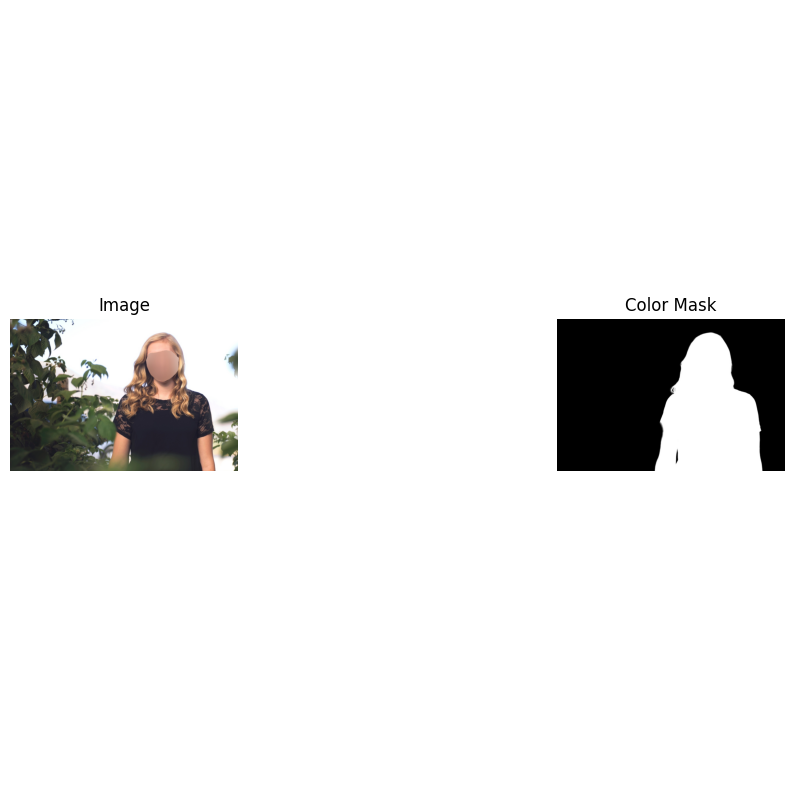

In [175]:
a = 2
# img_files[a], mask_files[a]

img = cv2.imread(img_files[a])
mask = cv2.imread(mask_files[a], cv2.IMREAD_GRAYSCALE)
# std_mask = cv2.imread(standardized_mask_files[a], cv2.IMREAD_GRAYSCALE)
mask_color = cv2.imread(mask_files[a])
fig, axs = plt.subplots(1,3, figsize=(10,10))
# Display the first image in the first subplot
axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
axs[0].set_title("Image")

# Display the second image in the second subplot
# axs[1].imshow(std_mask)
# axs[1].set_title("Mask")

axs[2].imshow(mask_color)
axs[2].set_title("Color Mask")

# Remove the axis labels
for ax in axs:
    ax.axis("off")
plt.show()

In [161]:
# for i in np.unique(std_mask):
#     image_array_test = std_mask.copy()
#     image_array_test_mono = np.where(image_array_test == i,1,0)
#     print(i)
#     plt.imshow(image_array_test_mono, cmap='viridis')
#     plt.show()

In [176]:
type(img)

numpy.ndarray

In [6]:
len(boxes)

2

In [4]:
from PIL import Image
def scale_img(boxes, scale, img_path, mask_path,  new_img_path, new_mask_path):
    for i in range(len(boxes)):
        original_image = Image.open(img_path)
        original_mask = Image.open(mask_path)
        # top_left = (boxes[0][0], boxes[0][1]) 
        max_dim = max(boxes[0][2], boxes[0][3])

        side_length = max_dim * scale
        center_x = boxes[i][0] + (boxes[i][2]/2)
        center_y = boxes[i][1] + (boxes[i][3]/2)
        half_side_length = side_length // 2
        # Get the width and height of the image
        image_width, image_height = original_image.size

        # Calculate bounding box corners
        x1 = max(0, center_x - half_side_length)
        y1 = max(0, center_y - half_side_length)
        x2 = min(image_width, center_x + half_side_length)
        y2 = min(image_height, center_y + half_side_length)

        # Adjust width or height to make the box square
        box_width = x2 - x1
        box_height = y2 - y1

        if box_width > box_height:
            # Expand height
            diff = box_width - box_height
            y1 = max(0, y1 - diff // 2)
            y2 = min(image_height, y2 + diff // 2)
        elif box_height > box_width:
            # Expand width
            diff = box_height - box_width
            x1 = max(0, x1 - diff // 2)
            x2 = min(image_width, x2 + diff // 2)


        top_left = (x1, y1)
        bottom_right = (x2, y2)
        # bottom_right = ((boxes[0][0] + max_dim) * scale, (boxes[0][1] + max_dim) * scale)
        cropped_image = original_image.crop((*top_left, *bottom_right))
        cropped_image.save(new_img_path + '_cropped_' + str(i) + '.jpg')
        cropped_mask = original_mask.crop((*top_left, *bottom_right))
        cropped_mask.save(new_mask_path + '_cropped_' + str(i) + '.png')
        print("New Image Saved")


In [5]:
img_path = '/ocean/projects/cis220031p/abdulhan/VLR/P3M-10k/train/blurred_image'
mask_path = '/ocean/projects/cis220031p/abdulhan/VLR/P3M-10k/train/mask'

img_file_names = sorted([f for f in os.listdir(img_path)])
mask_file_names = sorted([f for f in os.listdir(mask_path)])

img_files = [os.path.join(img_path, file_name) for file_name in img_file_names]
mask_files = [os.path.join(mask_path, file_name) for file_name in mask_file_names]

In [6]:
len(img_file_names)

9421

In [7]:
len(mask_files)

9421

In [8]:

new_img_file_path = '/ocean/projects/cis220031p/abdulhan/VLR/testVLR/images/'
new_mask_file_path = '/ocean/projects/cis220031p/abdulhan/VLR/testVLR/masks/'
for img_path, mask_path, img_file_name, mask_file_name in zip(img_files, mask_files, img_file_names, mask_file_names):
    img_path = img_path
    mask_path = mask_path
    img = cv2.imread(img_path)
    boxes, scores, classids, kpts = YOLOv8_face_detector.detect(img)
    print(boxes)
    scale_img(boxes=boxes, scale=2, img_path=img_path, mask_path=mask_path, new_img_path=(new_img_file_path+img_file_name[:-4]), new_mask_path=(new_mask_file_path+mask_file_name[:-4]))

nothing detect
[]
[[375.0871895  638.10392845 213.93460012 304.6621801 ]]
New Image Saved
[[432.95305519 180.68187262 169.78576764 221.82471922]]
New Image Saved
[[939.85805991 120.49551424 180.89547104 337.95467128]]
New Image Saved
[[760.82559678 116.03163433 206.11268542 262.15607229]]
New Image Saved
[[670.8338815  252.26510904 276.3467014  383.03377494]]
New Image Saved
[[626.49501448 244.87755394 428.4965865  571.82573906]]
New Image Saved
nothing detect
[]
nothing detect
[]
nothing detect
[]
[[658.79660003 363.40410777  59.28166332 118.25082157]]
New Image Saved
[[750.90920138 151.10651285  73.40405369  98.15402427]]
New Image Saved
nothing detect
[]
[[413.61852785 180.25278016 226.05127337 279.22400546]]
New Image Saved
nothing detect
[]
nothing detect
[]
nothing detect
[]
[[770.32475446 402.30574977 165.51357366 236.90402659]]
New Image Saved
nothing detect
[]
[[693.42547462 301.19389821 205.88421887 293.69076086]]
New Image Saved
[[824.82893673 309.94411552  84.18288103 110.0

: 

In [4]:
img_path = '/ocean/projects/cis220031p/abdulhan/VLR/testVLR/images/'
mask_path = '/ocean/projects/cis220031p/abdulhan/VLR/testVLR/masks/'

img_file_names = sorted([f for f in os.listdir(img_path)])
mask_file_names = sorted([f for f in os.listdir(mask_path)])

In [5]:
len(img_file_names)

209

In [13]:
len(mask_file_names)

5356

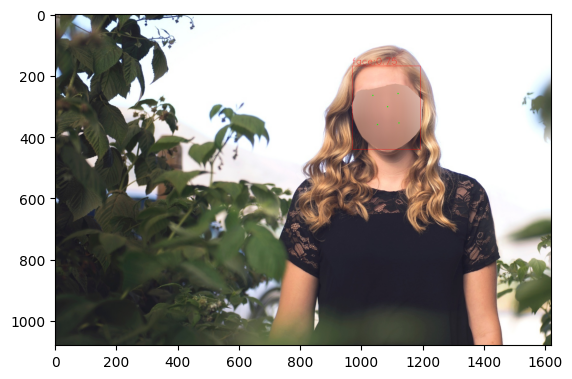

In [179]:
# Detect Objects
boxes, scores, classids, kpts = YOLOv8_face_detector.detect(img)
# Draw detections
dstimg_bgr = YOLOv8_face_detector.draw_detections(img.copy(), boxes, scores, kpts)
dstimg_rgb = cv2.cvtColor(dstimg_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(dstimg_rgb)

# Plotting stored landmarks and bbox from json

In [54]:
# Reading bbox info:
with open(bbox_files[a], 'r') as f:
    data_regressor = json.load(f)
    
# Getting info from bbox:
lmks_face = np.array(data_regressor['lmks_face'])
bbox = np.array((data_regressor['bbox']))

bbox = bbox.reshape(1,-1)

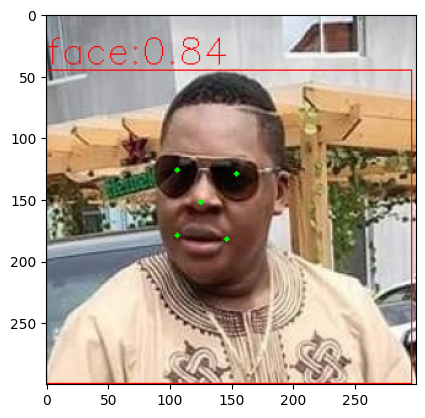

In [55]:
stored_bgr = YOLOv8_face_detector.draw_detections(img.copy(), bbox, scores, kpts)
stored_rgb = cv2.cvtColor(stored_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(stored_rgb)

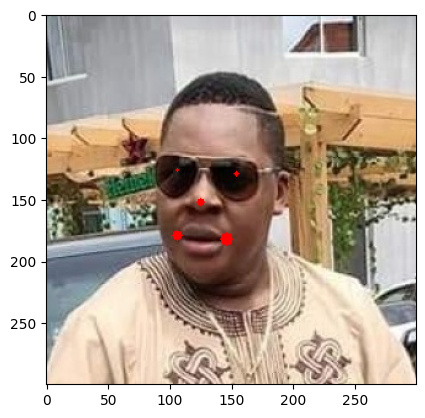

In [56]:
# Plotting landmarks from json
''' 
Landmark sequence:
0: Left Eye
1: Right Eye
2: Nose
3: Lip Left Corner
4: Lip Right Corner
'''

# Loop through landmarks and plot points
img_with_lmks = img.copy()
img_with_lmks = cv2.cvtColor(img_with_lmks, cv2.COLOR_BGR2RGB)

for i in range(5):
    x = int(lmks_face[0][i])
    y = int(lmks_face[1][i])
    # Color of the markers in RGB format
    cv2.circle(img_with_lmks, (x,y), i+1, (255,0,0), -1)

plt.imshow(img_with_lmks)

# Testing Datasets

In [57]:
def get_midpoint(lmks_arr, idx_1, idx_2):
    x1, y1 = lmks_arr[0][idx_1], lmks_arr[1][idx_1]
    x2, y2 = lmks_arr[0][idx_2], lmks_arr[1][idx_2]

    # Calculate midpoint
    x_midpoint = (x1 + x2) // 2
    y_midpoint = (y1 + y2) // 2

    return [x_midpoint, y_midpoint]

def dist_between_lmks(lmks_arr, idx_1, idx_2=None, custom=None):
    """
    Calculate distance between landmarks or custom point.
    
    Args:
        lmks_arr (ndarray): Landmark array shape (2, N) with x, y coords.
        idx_1 (int): Index of first landmark. 
        idx_2 (int, optional): Index of second landmark.  
        custom (list, optional): [x, y] custom point instead of idx_2.
        
    Returns: float16
    """
    lmks_arr = lmks_arr.astype(np.float16)
    if idx_2 is not None:
        x1, y1 = lmks_arr[0][idx_1], lmks_arr[1][idx_1]
        x2, y2 = lmks_arr[0][idx_2], lmks_arr[1][idx_2]
        # c1 = np.array([x1, y1])
        # c2 = np.array([x2, y2])
    else:
        x1, y1 = lmks_arr[0][idx_1], lmks_arr[1][idx_1]
        x2, y2 = custom[0], custom[1]
        # c1 = np.array([x1, y1])
        # c2 = np.array([x2, y2])

    # dist = np.linalg.norm(x2 - x1)
    dist = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return np.float16(dist)

d1 = dist_between_lmks(lmks_face, idx_1=0, idx_2=1)
print(f'd1: {d1}')
# d2 = dist_between_lmks(lmks_face, idx_1=0, idx_2=1)
# print(f'd2: {d2}')
eyes_midpoint = get_midpoint(lmks_arr=lmks_face, idx_1=0, idx_2=1)
d3 = dist_between_lmks(lmks_face, idx_1=3, custom=eyes_midpoint)
print(f'd3: {d3}')


d1: 48.25
d3: 56.46875


In [58]:
width, height, _ = img.shape
print(width, height)

300 300


In [59]:
threshold = 0.2

In [56]:
'''
Threshold for filtering images based on ratio of the ditance 
between the nose and the midpoint of the eye landmarks and the width of the image
'''
threshold = 0.2

filtered_images = []
bad_paths = []
sum_d3 = 0
list_d3 = []
for a in tqdm(range(40000)):
    try:
        img = cv2.imread(img_files[a])
        mask = cv2.imread(mask_files[a], cv2.IMREAD_GRAYSCALE)
        std_mask = cv2.imread(standardized_mask_files[a], cv2.IMREAD_GRAYSCALE)

        # Reading bbox info:
        with open(bbox_files[a], 'r') as f:
            data_regressor = json.load(f)
            
        # Getting info from bbox:
        lmks_face = np.array(data_regressor['lmks_face'])
        bbox = np.array((data_regressor['bbox']))

        bbox = bbox.reshape(1,-1)
        
        d1 = dist_between_lmks(lmks_face, idx_1=0, idx_2=1)
        # print(f'd1: {d1}')
        # d2 = dist_between_lmks(lmks_face, idx_1=0, idx_2=1)
        # print(f'd2: {d2}')
        eyes_midpoint = get_midpoint(lmks_arr=lmks_face, idx_1=0, idx_2=1)
        d3 = dist_between_lmks(lmks_face, idx_1=3, custom=eyes_midpoint)
        # print(f'd3: {d3}')

        width, height, _ = img.shape
        sum_d3 += d3 
        if (d3/width) > 0.2:
            filtered_images.append(a)
        list_d3.append((a, d3))
    except:
        bad_paths.append(a)
print(f'Mean d3: {sum_d3/40000}')

100%|██████████| 40000/40000 [05:26<00:00, 122.43it/s]

Mean d3: 38.46808203125


In [66]:
# Sort the list of distances and identify image idx corresponding to the largest values
sorted_list_d3 = sorted(list_d3, key=lambda x: x[1])
sorted_list_d3[:-10:-1]

[(34613, 56.6),
 (8505, 56.47),
 (23999, 54.88),
 (26434, 54.56),
 (10401, 54.2),
 (5000, 53.7),
 (21816, 53.44),
 (38636, 53.2),
 (1448, 53.0)]

# Filter based on mask proximity to the edge

### Strict filtering with mask not touching the edge

In [17]:
# idx 13 for clothing, 18 for skin
min_row, max_row = 0, int(0.99*height) 
min_col, max_col = 0, 2

value = 18

res = (std_mask[min_row:max_row+1, min_col:max_col+1] == value).any()
res

True

In [38]:
filtered_images = []
bad_paths = []
strict_filter_out = []
for a in tqdm(range(40000)):
    try:
        # img = cv2.imread(img_files[a])
        # mask = cv2.imread(mask_files[a], cv2.IMREAD_GRAYSCALE)
        std_mask = cv2.imread(standardized_mask_files[a], cv2.IMREAD_GRAYSCALE)
        width, height = std_mask.shape
        # idx 13 for clothing, 18 for skin
        value = 18
        min_row, max_row = 0, int(0.99*height) 
        min_col, max_col = 0, 2

        l = (std_mask[min_row:max_row+1, min_col:max_col+1] == value).any()

        if l:
            strict_filter_out.append(a)
            continue
            
        min_row, max_row = 0, int(0.99*height) 
        min_col, max_col = width-2, width-1

        r = (std_mask[min_row:max_row+1, min_col:max_col+1] == value).any()

        if r:
            strict_filter_out.append(a)
        
    except:
        bad_paths.append(a)
print(f'Dataset has {len(strict_filter_out)} images touching the edges')

100%|██████████| 40000/40000 [00:41<00:00, 956.86it/s]

Dataset has 3225 images touching the edges


In [39]:
strict_filter_out[:10]

[69, 75, 111, 113, 114, 118, 132, 150, 160, 174]

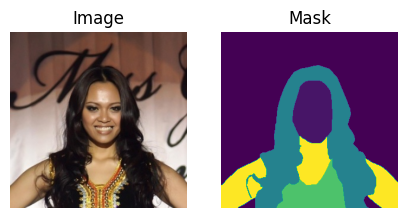

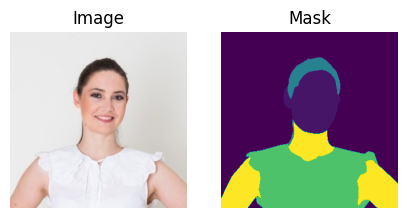

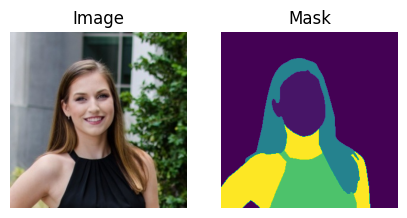

In [61]:
'''
Visualizing strict filter
'''
for b in strict_filter_out[:3]:
    img = cv2.imread(img_files[b])
    mask = cv2.imread(mask_files[b], cv2.IMREAD_GRAYSCALE)
    std_mask = cv2.imread(standardized_mask_files[b], cv2.IMREAD_GRAYSCALE)
    mask_color = cv2.imread(mask_files[a])
    fig, axs = plt.subplots(1,2, figsize=(5,5))
    # Display the first image in the first subplot
    axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axs[0].set_title("Image")

    # Display the second image in the second subplot
    axs[1].imshow(std_mask)
    axs[1].set_title("Mask")

    # Remove the axis labels
    for ax in axs:
        ax.axis("off")
    plt.show()

### Less strict filtering 

In [62]:
# idx 13 for clothing, 18 for skin
min_row, max_row = 0, int(0.8*height) 
min_col, max_col = 0, 2

value = 18

res = (std_mask[min_row:max_row+1, min_col:max_col+1] == value).any()
np.unique(res)

array([False])

In [63]:
filtered_images = []
bad_paths = []
lenient_filter_out = []
for a in tqdm(range(40000)):
    try:
        # img = cv2.imread(img_files[a])
        # mask = cv2.imread(mask_files[a], cv2.IMREAD_GRAYSCALE)
        std_mask = cv2.imread(standardized_mask_files[a], cv2.IMREAD_GRAYSCALE)
        width, height = std_mask.shape
        # idx 13 for clothing, 18 for skin

        value = 18
        min_row, max_row = 0, int(0.8*height) 
        min_col, max_col = 0, 2

        l = (std_mask[min_row:max_row+1, min_col:max_col+1] == value).any()

        if l:
            lenient_filter_out.append(a)
            continue
            
        min_row, max_row = 0, int(0.8*height) 
        min_col, max_col = width-2, width-1

        r = (std_mask[min_row:max_row+1, min_col:max_col+1] == value).any()

        if r:
            lenient_filter_out.append(a)
        
    except:
        bad_paths.append(a)
print(f'Dataset has at least {len(lenient_filter_out)} images touching the edges')

100%|██████████| 40000/40000 [00:41<00:00, 958.70it/s]

Dataset has at least 686 images touching the edges


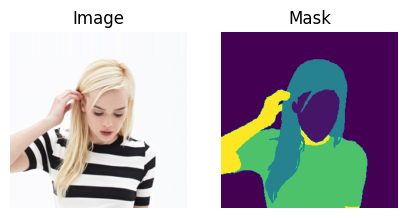

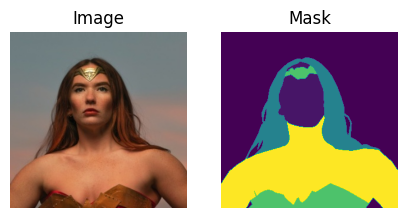

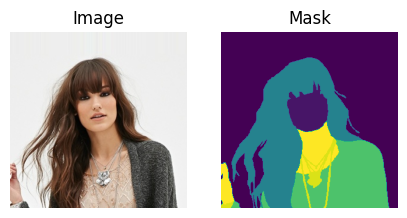

In [64]:
'''
Visualizing lenient filter
'''
# img_files[a], mask_files[a]
for b in lenient_filter_out[:3]:
    img = cv2.imread(img_files[b])
    mask = cv2.imread(mask_files[b], cv2.IMREAD_GRAYSCALE)
    std_mask = cv2.imread(standardized_mask_files[b], cv2.IMREAD_GRAYSCALE)
    mask_color = cv2.imread(mask_files[a])
    fig, axs = plt.subplots(1,2, figsize=(5,5))
    # Display the first image in the first subplot
    axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axs[0].set_title("Image")

    # Display the second image in the second subplot
    axs[1].imshow(std_mask)
    axs[1].set_title("Mask")

    # Remove the axis labels
    for ax in axs:
        ax.axis("off")
    plt.show()

### Filtering with predefined threshold for number of pixels of mask near the border

In [92]:
# left edge
min_row, max_row = 0, int(1*height) 
min_col, max_col = 0, 10

# right edge
min_row, max_row = 0, int(1*height) 
min_col, max_col = (width-10), width

# top edge
min_row, max_row = 0, int(1*height) 
min_col, max_col = 0, 10

value = 18
sum_threshold = 500
count = (std_mask[min_row:max_row+1, min_col:max_col+1] == value).sum()
print(count > sum_threshold)

False


In [88]:
filtered_images = []
bad_paths = []
value = [13, 18]
sum_threshold = 1150

for a in tqdm(range(40000)):
    try:
        # img = cv2.imread(img_files[a])
        # mask = cv2.imread(mask_files[a], cv2.IMREAD_GRAYSCALE)
        std_mask = cv2.imread(standardized_mask_files[a], cv2.IMREAD_GRAYSCALE)
        width, height = std_mask.shape

        # left edge
        min_row, max_row = 0, int(1*height) 
        min_col, max_col = 0, 10

        l_count = (std_mask[min_row:max_row+1, min_col:max_col+1] == value[0]).sum()
        l_count += (std_mask[min_row:max_row+1, min_col:max_col+1] == value[1]).sum()
        
        # right edge
        min_row, max_row = 0, int(1*height) 
        min_col, max_col = (width-10), width   

        r_count = (std_mask[min_row:max_row+1, min_col:max_col+1] == value[0]).sum()
        r_count += (std_mask[min_row:max_row+1, min_col:max_col+1] == value[1]).sum()

        count = l_count + r_count
        if count > sum_threshold:
            filtered_images.append((a, count))
    except:
        bad_paths.append(a)
print(f'Dataset has {len(filtered_images)} images with large portions touching the edges')

100%|██████████| 40000/40000 [00:42<00:00, 934.48it/s]

Dataset has 607 images with large portions touching the edges


1257


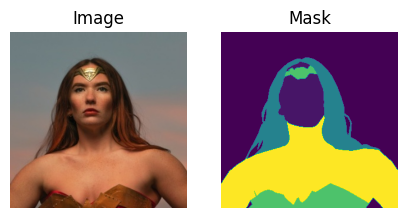

1848


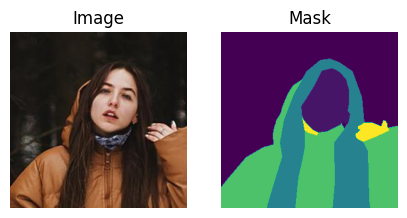

1248


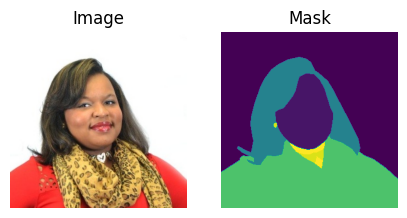

1242


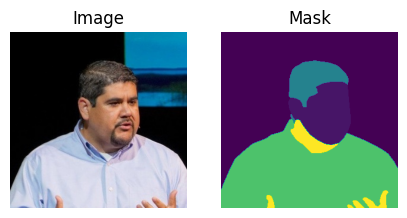

1525


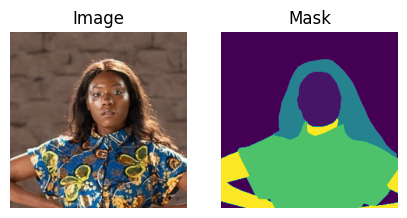

1496


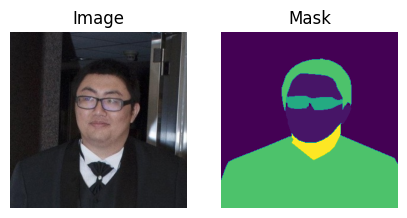

1195


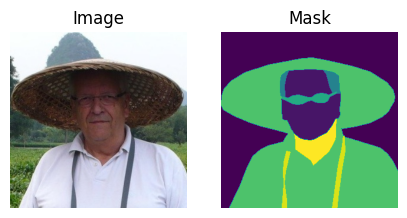

1234


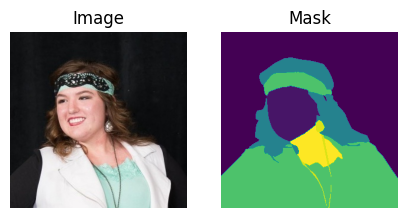

1309


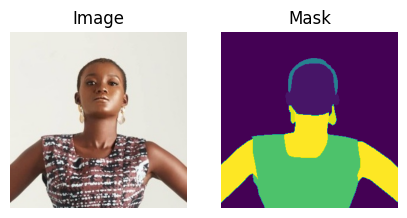

1212


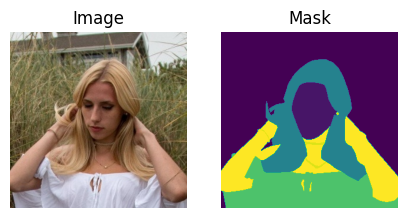

1263


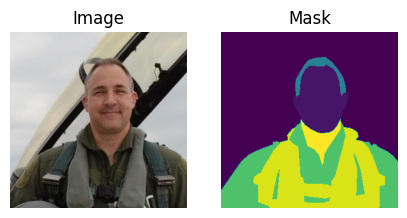

1198


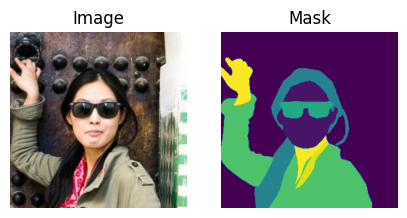

1389


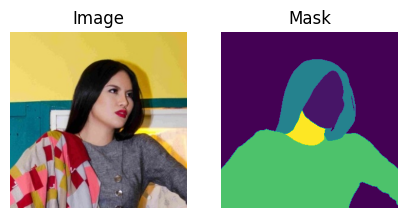

1230


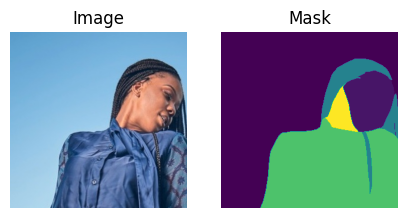

1674


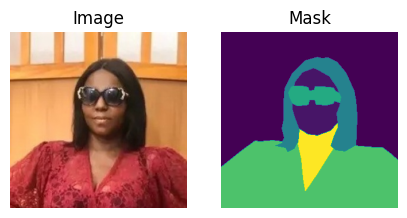

1281


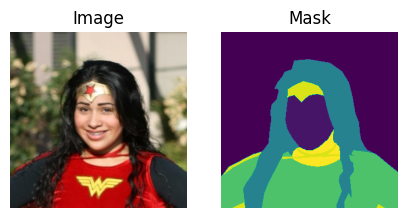

1156


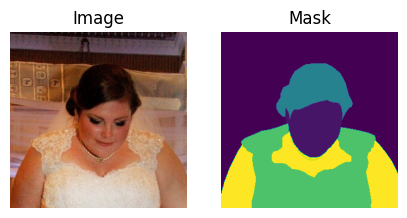

1167


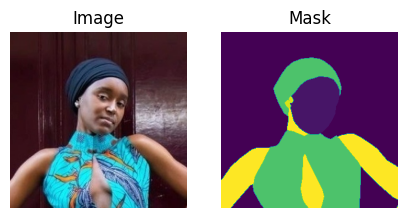

1402


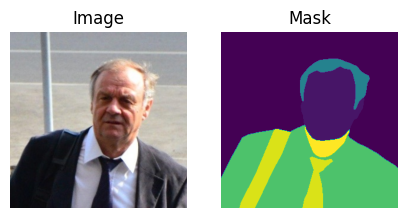

1286


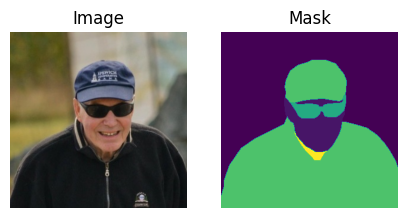

1388


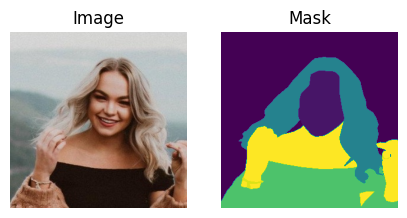

1706


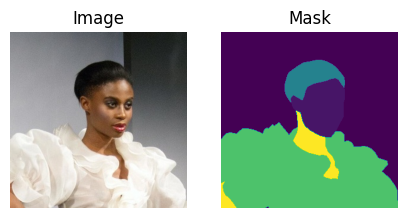

1189


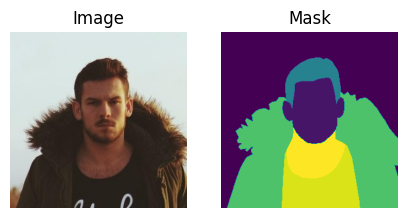

1373


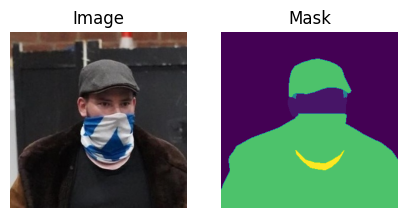

1658


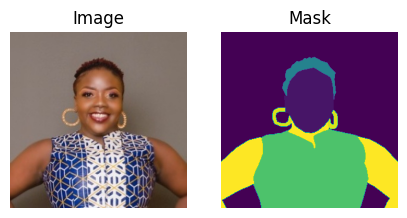

2119


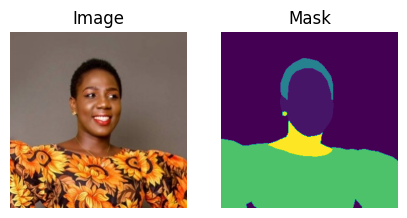

1279


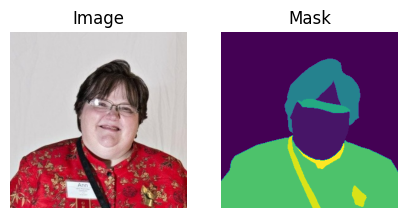

1781


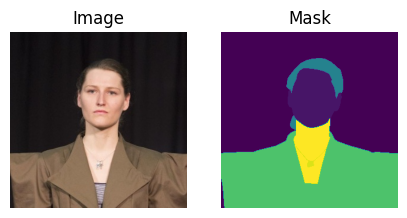

1480


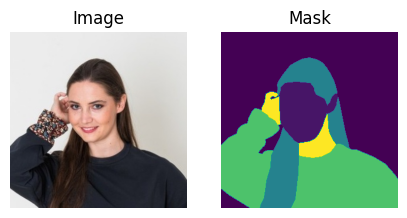

1233


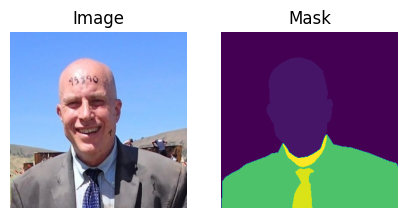

In [89]:
'''
Visualizing filter based on mask pixels in sensitive zones
'''
# img_files[a], mask_files[a]
for b, c in filtered_images[:30]:
    img = cv2.imread(img_files[b])
    mask = cv2.imread(mask_files[b], cv2.IMREAD_GRAYSCALE)
    std_mask = cv2.imread(standardized_mask_files[b], cv2.IMREAD_GRAYSCALE)
    mask_color = cv2.imread(mask_files[a])
    fig, axs = plt.subplots(1,2, figsize=(5,5))
    # Display the first image in the first subplot
    axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axs[0].set_title("Image")

    # Display the second image in the second subplot
    axs[1].imshow(std_mask)
    axs[1].set_title("Mask")
    print(c)
    # Remove the axis labels
    for ax in axs:
        ax.axis("off")
    plt.show()